In [1]:
import os, sys, keras, numpy as np, pickle, pandas

FIGSIZE=(12,8)

Using TensorFlow backend.


In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
with open('../data/demand/game0labels.pickle', 'rb') as f:
    y = pickle.load(f)
with open('../data/demand/game0training.pickle', 'rb') as f:
    x = pickle.load(f)

In [4]:
x = np.array(x)
y = np.array(y)

How does the content of a customer data set look like?

In [26]:
x[0,0,:]

array([10.  ,  1.  ,  0.  ,  0.  ,  0.  , -0.5 ,  0.  ,  0.  ,  0.  ,
        0.  ,  1.  ,  1.  , 24.  , -1.  , 11.  ,  0.  ,  0.47])

And the usage data?

In [24]:
y.shape

(200, 1453)

In [25]:
y[0].shape

(1453,)

## Customer usages compared
Typical Usage profile by a customer

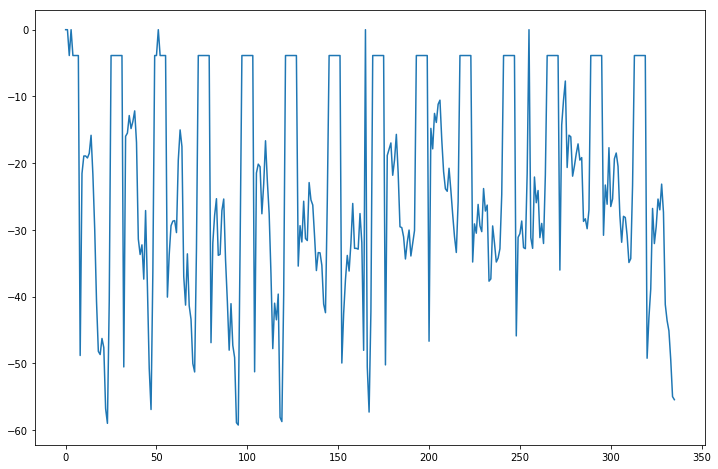

In [119]:
ts = pandas.Series(y[0][0:24*14])
ts.plot(figsize=FIGSIZE)

Let's plot the usage of all customers combined

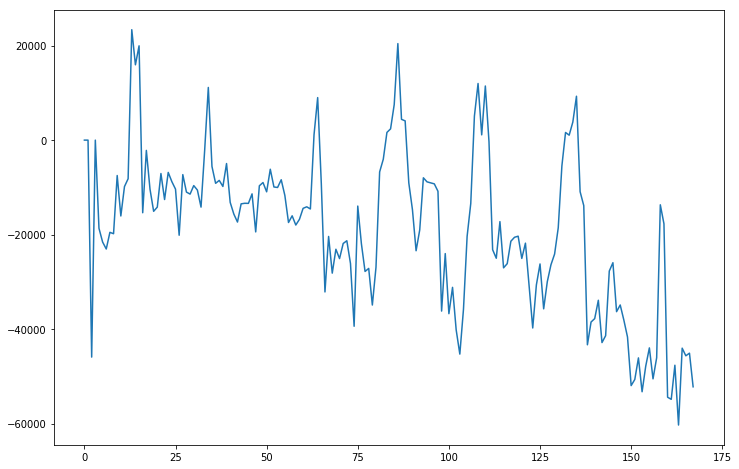

In [120]:
sum_all = np.sum(y, axis=0)
ts = pandas.Series(sum_all[0:24*7])
ts.plot(figsize=FIGSIZE)

In [59]:
len(y)

200

Let's get some overview on the size of the usages by the different customers. Let's look at the sum of usage by 1,2,4,8,16, ... customers

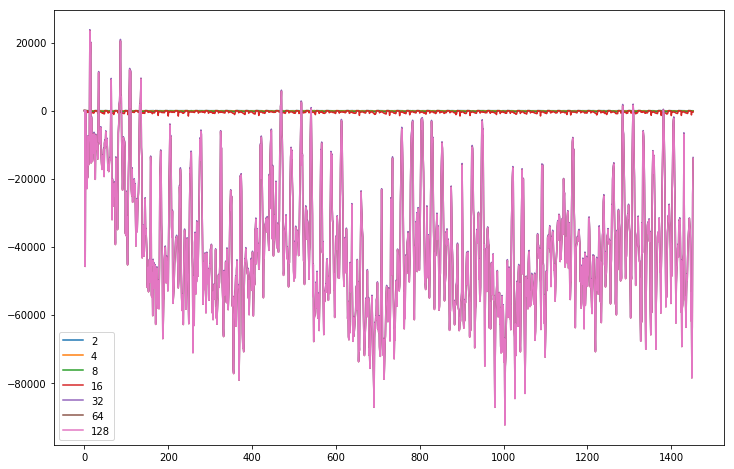

In [121]:
sum_some = []

#making a series of potencies of 2
i = 1
columns = []
while True:
    i = i*2
    
    if i > len(y):
        break
    columns.append(i)
    
for i in columns:
    sum_some.append(np.sum(y[0:i], axis=0))



sum_some = np.array(sum_some).transpose()
df = pandas.DataFrame(sum_some, columns=list(columns))
df.plot(figsize=FIGSIZE)


Interesting. It seems there are some very large players that strongly influence the field. Let's do the same again but with just 14 days worth of data

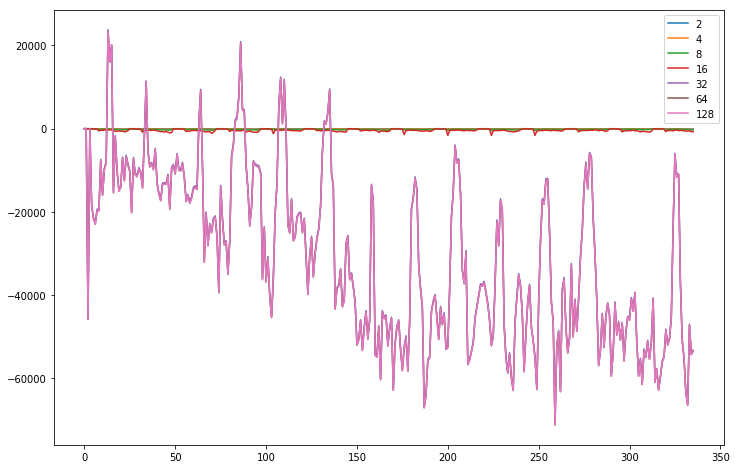

In [122]:
df = pandas.DataFrame(sum_some[:14*24], columns=list(columns))
df.plot(figsize=FIGSIZE)

## Weather influence on usage

Strong tendency across a one week period. The first week seems to use less than the second. Maybe we can bring the sunshine in here to see what impact the weather has

In [85]:
from sklearn import preprocessing
#sum_scaled = preprocessing.RobustScaler().fit_transform(sum_some[-1])
# wind = 14, cloud_cover = 16
winds = x[0,:,14]
cloud = x[0,:,16]

In [86]:
winds.shape

(1453,)

In [87]:
cloud.shape

(1453,)

In [95]:
last = sum_some[:,-1]
last.shape

(1453,)

In [91]:
data = np.array([winds,cloud,sum_some[-1]])

In [111]:
cloud_wind_usage = np.stack([winds,cloud,last])
cloud_wind_usage = preprocessing.normalize(cloud_wind_usage)
cloud_wind_usage.shape

(3, 1453)

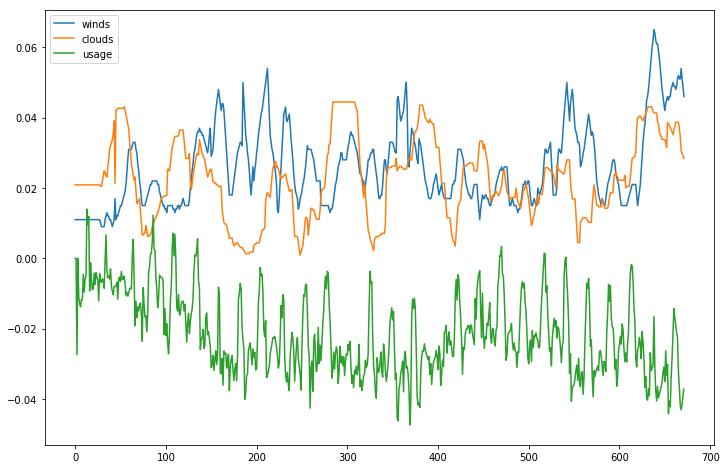

In [123]:
df_data = cloud_wind_usage[:,:28*24].transpose()
df = pandas.DataFrame(df_data, columns=["winds", "clouds", "usage"])
df.plot(figsize=FIGSIZE)

I don't know about you but I don't see a pattern. Let's look at quantiles to see how much the biggest / smallest fish in the pond are using

In [125]:
#getting 2 weeks worth of data
two_weeks = y[:,:14*24]
two_weeks_summed = np.sum(two_weeks, axis=1)

In [127]:
two_weeks_summed.shape

(200,)

Okay so we have the summed usage of two weeks of all customers. Let's group them in 10 percentiles (sort first), then get a pie diagramm showing the market share of the 10 groups

In [131]:
two_weeks_summed.sort()

In [137]:
below_zero = two_weeks_summed[two_weeks_summed < 0]
below_zero.shape

(146,)

In [141]:
above_zero = two_weeks_summed[two_weeks_summed > 0]
above_zero.shape

(23,)

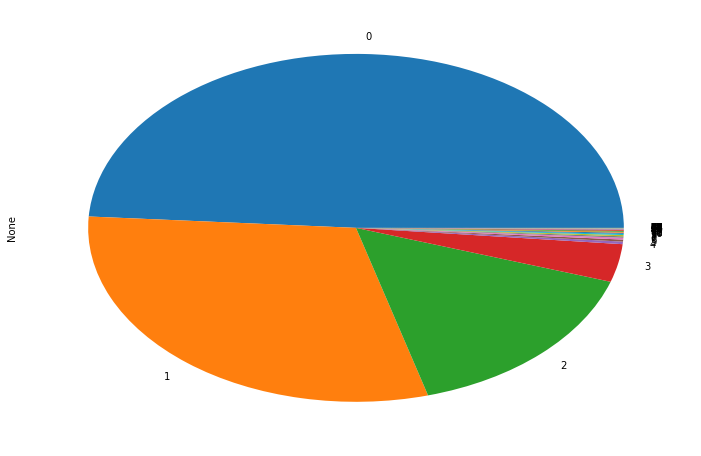

In [157]:
import math
#first the consumers split:
parts = 50
per_percentile = math.floor(below_zero.shape[0] / parts)

percentiles = []
summi = 0
for i,c  in enumerate(below_zero):
    if i % per_percentile is 0 and i is not 0:
        percentiles.append(summi)
        summi = 0
    summi += c
percentiles = np.absolute(percentiles)
#ndexes = range(0,100,2)

pandas.Series(percentiles).plot.pie(figsize=FIGSIZE)

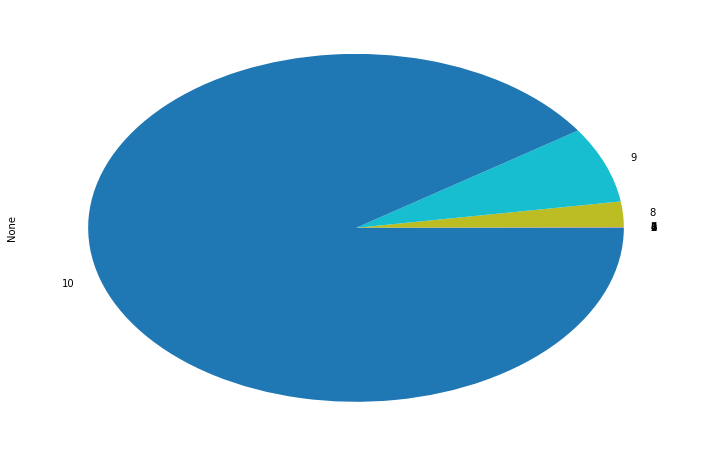

In [159]:
#first the consumers split:
parts = 10
per_percentile = math.floor(above_zero.shape[0] / parts)

percentiles = []
summi = 0
for i,c  in enumerate(above_zero):
    if i % per_percentile is 0 and i is not 0:
        percentiles.append(summi)
        summi = 0
    summi += c
percentiles = np.absolute(percentiles)
#ndexes = range(0,100,2)

pandas.Series(percentiles).plot.pie(figsize=FIGSIZE)

The largest 146/50 --> 3% consume about half the energy in the market. However the powerTAC simulation also makes use of "population level" customers, meaning some customers really are just about 10k simulated in union. These however can have multiple contracts with various tariff offerers. So this number has to be taken with a grain of salt

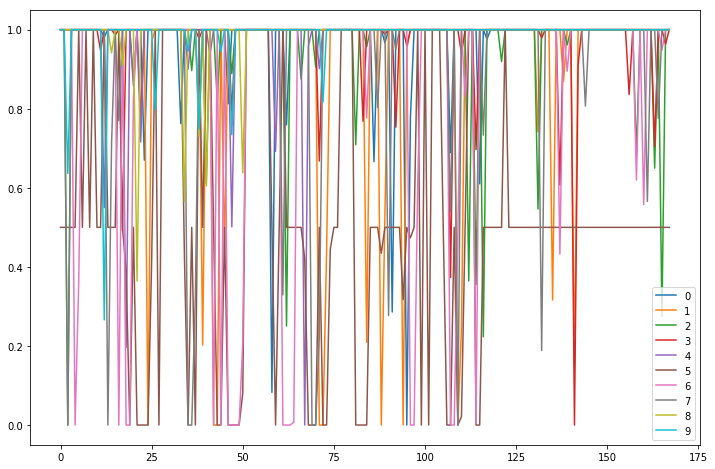

In [169]:
#sum_all = np.sum(y, axis=0)
#sum_all.shape
sum_minmax = preprocessing.MinMaxScaler().fit_transform(y[100:110].T)
ts = pandas.DataFrame(sum_minmax[0:24*7])
ts.plot(figsize=FIGSIZE)

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots

In [114]:
market = y.sum(axis=0)
single1 = y[44]
single2 = y[-15]
population = y[22]
data = np.array([market, population,single1, single2]).transpose()[500:668]
data = pd.DataFrame(data)



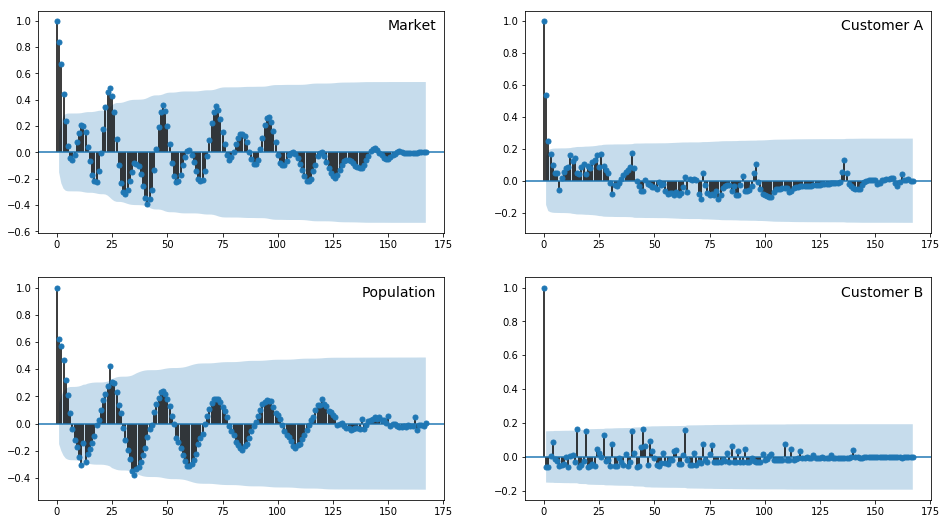

In [115]:
def label(ax, string):
    ax.annotate(string, (1, 1), xytext=(-8, -8), ha='right', va='top',
                size=14, xycoords='axes fraction', textcoords='offset points')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 9))
#fig.tight_layout()

tsaplots.plot_acf(data[0], axes[0][0])
label(axes[0][0], 'Market')

tsaplots.plot_acf(data[1], axes[1][0])
label(axes[1][0], 'Population')

tsaplots.plot_acf(data[2], axes[0][1])
label(axes[0][1], 'Customer A')

tsaplots.plot_acf(data[3], axes[1][1])
label(axes[1][1], 'Customer B')


for ax in axes.flat:
    ax.set(title='', xlabel='')
plt.show()